<a href="https://colab.research.google.com/github/MJ199999/WaterPotability/blob/main/WaterQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
data = pd.read_csv("water_potability.csv")

In [53]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [55]:
# from dataprep.eda import create_report
# create_report(data)

In [56]:
# data2 = data.dropna(axis=0)
data2 = data

print(data2.isna().sum())

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


## Remove Outliers

In [57]:
norm_upper_limit = data["Sulfate"].mean() + 3 * data["Sulfate"].std()
norm_lower_limit = data["Sulfate"].mean() - 3 * data["Sulfate"].std()

data_new = data[(data["Sulfate"] > norm_lower_limit) & (data["Sulfate"] < norm_upper_limit)]


norm_upper_limit = data["ph"].mean() + 3 * data["ph"].std()
norm_lower_limit = data["ph"].mean() - 3 * data["ph"].std()

data_new = data[(data["ph"] > norm_lower_limit) & (data["ph"] < norm_upper_limit)]


norm_upper_limit = data["Trihalomethanes"].mean() + 3 * data["Trihalomethanes"].std()
norm_lower_limit = data["Trihalomethanes"].mean() - 3 * data["Trihalomethanes"].std()

data_new = data[(data["Trihalomethanes"] > norm_lower_limit) & (data["Trihalomethanes"] < norm_upper_limit)]


norm_upper_limit = data["Solids"].mean() + 3 * data["Solids"].std()
norm_lower_limit = data["Solids"].mean() - 3 * data["Solids"].std()

data_new = data[(data["Solids"] > norm_lower_limit) & (data["Solids"] < norm_upper_limit)]


norm_upper_limit = data["Chloramines"].mean() + 3 * data["Chloramines"].std()
norm_lower_limit = data["Chloramines"].mean() - 3 * data["Chloramines"].std()

data_new = data[(data["Chloramines"] > norm_lower_limit) & (data["Chloramines"] < norm_upper_limit)]


norm_upper_limit = data["Conductivity"].mean() + 3 * data["Conductivity"].std()
norm_lower_limit = data["Conductivity"].mean() - 3 * data["Conductivity"].std()

data_new = data[(data["Conductivity"] > norm_lower_limit) & (data["Conductivity"] < norm_upper_limit)]


norm_upper_limit = data["Organic_carbon"].mean() + 3 * data["Organic_carbon"].std()
norm_lower_limit = data["Organic_carbon"].mean() - 3 * data["Organic_carbon"].std()

data_new = data[(data["Organic_carbon"] > norm_lower_limit) & (data["Organic_carbon"] < norm_upper_limit)]


norm_upper_limit = data["Turbidity"].mean() + 3 * data["Turbidity"].std()
norm_lower_limit = data["Turbidity"].mean() - 3 * data["Turbidity"].std()

data_new = data[(data["Turbidity"] > norm_lower_limit) & (data["Turbidity"] < norm_upper_limit)]


norm_upper_limit = data["Hardness"].mean() + 3 * data["Hardness"].std()
norm_lower_limit = data["Hardness"].mean() - 3 * data["Hardness"].std()

data_new = data[(data["Hardness"] > norm_lower_limit) & (data["Hardness"] < norm_upper_limit)]

### Fill Na - means

In [89]:
# Split train and test data
from sklearn.model_selection import train_test_split

X = data_new.drop(['Potability'], axis=1)
y = data_new.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)

# Classify each dataset by label

train_potable = train[train['Potability']==1]
train_notpotable = train[train['Potability']==0]
test_potable = test[test['Potability']==1]
test_notpotable = test[test['Potability']==0]

# Fill NA of ph with means
train_potable_ph_means = train_potable['ph'].mean()
train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_means)
train_notpotable_ph_means = train_notpotable['ph'].mean()
train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_means)
test_potable['ph'] = test_potable['ph'].fillna(train_potable_ph_means)
test_notpotable['ph'] = test_notpotable['ph'].fillna(train_notpotable_ph_means)

# fill NA of Sulfate
train_potable_SF_means = train_potable['Sulfate'].mean()
train_potable['Sulfate'] = train_potable['Sulfate'].fillna(train_potable_SF_means)
train_notpotable_SF_means = train_notpotable['Sulfate'].mean()
train_notpotable['Sulfate'] = train_notpotable['Sulfate'].fillna(train_notpotable_SF_means)
test_potable['Sulfate'] = test_potable['Sulfate'].fillna(train_potable_SF_means)
test_notpotable['Sulfate'] = test_notpotable['Sulfate'].fillna(train_notpotable_SF_means)

# Fill NA of Trihalomethanes
train_potable_TM_means = train_potable['Trihalomethanes'].mean()
train_potable['Trihalomethanes'] = train_potable['Trihalomethanes'].fillna(train_potable_TM_means)
train_notpotable_TM_means = train_notpotable['Trihalomethanes'].mean()
train_notpotable['Trihalomethanes'] = train_notpotable['Trihalomethanes'].fillna(train_potable_TM_means)
test_potable['Trihalomethanes'] = test_potable['Trihalomethanes'].fillna(train_potable_TM_means)
test_notpotable['Trihalomethanes'] = test_notpotable['Trihalomethanes'].fillna(train_notpotable_TM_means)

# 
train = pd.concat([train_potable, train_notpotable], axis=0)
test = pd.concat([test_potable, test_notpotable], axis=0)

#
train_X = train.drop(['Potability'], axis=1)
train_y = train.Potability
test_X = test.drop(['Potability'], axis=1)
test_y = test.Potability

<ipython-input-89-e06e47f4ec4f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_means)
<ipython-input-89-e06e47f4ec4f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_means)
<ipython-input-89-e06e47f4ec4f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [90]:
# Check NA
print('train data의 NA 개수:', train.isna().sum())
print('test data의 NA 개수:', test.isna().sum())

train data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64
test data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [91]:
from sklearn.utils import resample, shuffle

def sampling(train):
    train_potable = train[train['Potability']==1]
    train_notpotable = train[train['Potability']==0]
    df_minority_upsampled = resample(train_potable, replace=True, n_samples=1200)
    train_s = pd.concat([train_notpotable, df_minority_upsampled])
    train_s = shuffle(train_s)
    print(train_s.head(5))
    train_s_X = train_s.drop(['Potability'], axis=1)
    train_s_y =  train_s.Potability

    return train_s_X, train_s_y

train_s_X, train_s_y = sampling(train)

            ph    Hardness        Solids  Chloramines     Sulfate  \
3045  5.622807  194.463239  16119.340190     6.907987  336.648207   
2025  7.338826  229.978694  12603.400371     5.975488  351.318826   
1691  7.731315  169.049684  38356.226496     6.028454  297.329355   
988   7.082164  190.630636  26913.373486     4.649166  302.417529   
1572  5.675295  228.590392  39172.389643     6.014738  332.873673   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3045    408.459081       16.364724        76.631186   3.992957           0  
2025    370.860632       19.389337        79.971647   4.017061           1  
1691    525.879408       16.071120        74.909705   5.164284           0  
988     509.284869       16.198948        64.101951   3.452822           0  
1572    330.078613       11.423377        59.267099   5.021465           1  


In [92]:
from sklearn.preprocessing import StandardScaler
def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  return train_X, test_X

train_s_X, test_X = scaler_samples(train_s_X, test_X)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='f1')
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.809 total time=   0.1s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.825 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.839 total time=   0.1s
[CV 4/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.865 total time=   0.2s
[CV 5/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.843 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.830 total time=   0.3s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.824 total time=   0.3s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.848 total time=   0.3s
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             scoring='f1', verbose=3)

In [94]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 350}
RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       n_estimators=350)


In [95]:
grid_pred = grid.predict(test_X)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
    
print("accuracy: %.2f" % accuracy(test_y, grid_pred))

accuracy: 0.80


In [96]:
from sklearn.metrics import precision_score, f1_score

print('precision score: ', precision_score(test_y,grid_pred))
print('f1 score: ', f1_score(test_y, grid_pred))

precision score:  0.8235294117647058
f1 score:  0.632768361581921


In [97]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, grid_pred)

array([[205,  12],
       [ 53,  56]])

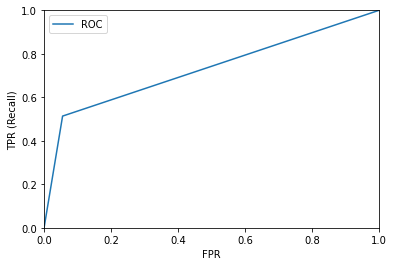

In [98]:
from sklearn.metrics import roc_curve
def roc_curve_plot(test_y, grid_pred):
    fprs, tprs, thresholds = roc_curve(test_y, grid_pred)
    
    plt.plot(fprs, tprs, label='ROC')
    
    start, end = plt.xlim()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR')
    plt.ylabel('TPR (Recall)')
    plt.legend()
    plt.show()

roc_curve_plot(test_y, grid_pred)

## 2. Fill NA - median

In [99]:
# Split train and test data
from sklearn.model_selection import train_test_split

X = data_new.drop(['Potability'], axis=1)
y = data_new.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)

# Classify each dataset by label

train_potable = train[train['Potability']==1]
train_notpotable = train[train['Potability']==0]
test_potable = test[test['Potability']==1]
test_notpotable = test[test['Potability']==0]

# Fill NA of ph with means
train_potable_ph_med = train_potable['ph'].median()
train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_med)
train_notpotable_ph_med = train_notpotable['ph'].median()
train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_med)
test_potable['ph'] = test_potable['ph'].fillna(train_potable_ph_med)
test_notpotable['ph'] = test_notpotable['ph'].fillna(train_notpotable_ph_med)

# fill NA of Sulfate
train_potable_SF_med = train_potable['Sulfate'].median()
train_potable['Sulfate'] = train_potable['Sulfate'].fillna(train_potable_SF_means)
train_notpotable_SF_med = train_notpotable['Sulfate'].median()
train_notpotable['Sulfate'] = train_notpotable['Sulfate'].fillna(train_notpotable_SF_med)
test_potable['Sulfate'] = test_potable['Sulfate'].fillna(train_potable_SF_med)
test_notpotable['Sulfate'] = test_notpotable['Sulfate'].fillna(train_notpotable_SF_med)

# Fill NA of Trihalomethanes
train_potable_TM_med = train_potable['Trihalomethanes'].median()
train_potable['Trihalomethanes'] = train_potable['Trihalomethanes'].fillna(train_potable_TM_med)
train_notpotable_TM_med = train_notpotable['Trihalomethanes'].median()
train_notpotable['Trihalomethanes'] = train_notpotable['Trihalomethanes'].fillna(train_potable_TM_med)
test_potable['Trihalomethanes'] = test_potable['Trihalomethanes'].fillna(train_potable_TM_med)
test_notpotable['Trihalomethanes'] = test_notpotable['Trihalomethanes'].fillna(train_notpotable_TM_med)

# 
train = pd.concat([train_potable, train_notpotable], axis=0)
test = pd.concat([test_potable, test_notpotable], axis=0)
print('train data의 NA 개수:', train.isna().sum())
print('test data의 NA 개수:', test.isna().sum())

#
train_X = train.drop(['Potability'], axis=1)
train_y = train.Potability
test_X = test.drop(['Potability'], axis=1)
test_y = test.Potability

train data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64
test data의 NA 개수: ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<ipython-input-99-bd453104f469>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_potable['ph'] = train_potable['ph'].fillna(train_potable_ph_med)
<ipython-input-99-bd453104f469>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_notpotable['ph'] = train_notpotable['ph'].fillna(train_notpotable_ph_med)
<ipython-input-99-bd453104f469>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [100]:
train_s_X, train_s_y = sampling(train)

            ph    Hardness        Solids  Chloramines     Sulfate  \
1885  5.648629  167.030097  14547.885478     7.735348  333.611617   
2709  7.040395  189.823418  20278.338272     6.799940  332.873673   
2292  6.195255  170.002291  16666.130805     9.483424  333.611617   
3227  7.679595  200.072928  32000.843911     7.633725  290.740337   
294   9.032661  121.441442  15618.170248     6.157491  372.927456   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
1885    347.792321       10.689769        75.288688   5.370004           0  
2709    314.834175       10.092087        46.629299   4.940015           1  
2292    457.068162       16.345685        79.369243   3.138971           0  
3227    583.608398       16.844509        39.367056   3.297525           1  
294     390.657226       15.030315        63.125617   4.927218           1  


In [101]:
train_s_X, test_X = scaler_samples(train_s_X, test_X)

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='f1')
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.848 total time=   0.1s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.830 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.827 total time=   0.1s
[CV 4/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.824 total time=   0.2s
[CV 5/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.798 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.857 total time=   0.3s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.851 total time=   0.3s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.848 total time=   0.3s
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             scoring='f1', verbose=3)

In [103]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 350}
RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, n_estimators=350)


In [104]:
grid_pred = grid.predict(test_X)
print("accuracy: %.2f" % accuracy(test_y, grid_pred))
print('precision score: ', precision_score(test_y,grid_pred))
print('f1 score: ', f1_score(test_y, grid_pred))

accuracy: 0.75
precision score:  0.75
f1 score:  0.5090909090909093


In [105]:
confusion_matrix(test_y, grid_pred)

array([[203,  14],
       [ 67,  42]])

## 3. Remove NA

In [106]:
data2 = data_new.dropna(axis=0)
X = data2.drop(['Potability'], axis=1)
y = data2.Potability

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

train = pd.concat([train_X, train_y], axis=1)

In [107]:
train_s_X, train_s_y = sampling(train)
train_s_X, test_X = scaler_samples(train_s_X, test_X)

            ph    Hardness        Solids  Chloramines     Sulfate  \
2559  5.870616  186.178376  18909.846006     8.494235  328.747315   
1984  7.732880  189.509811  47022.745845     8.226725  287.087053   
61    6.391354  213.017830  20965.478309     5.375560  327.650543   
1705  5.588130  220.817522   8730.312436     8.321897  300.220428   
816   5.452215  199.228468  14446.812390     7.689191  298.318418   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
2559    427.182531       13.300024        52.162419   3.728785           0  
1984    567.722281       14.980054        71.206209   3.510728           1  
61      369.338121       13.758105        17.915723   3.923749           0  
1705    412.708557        6.478626        80.637806   3.165618           0  
816     469.131951       14.020507        95.306239   5.190534           1  


In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
  
# define parameter search space
param_grid = {'n_estimators': [20, 50, 100, 200, 350, 500],
              'min_samples_leaf': [2, 10, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy']} 
clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, refit = True, cv=5, verbose = 3, scoring='f1')
  
# fit the model for grid search
grid.fit(train_s_X, train_s_y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.789 total time=   0.1s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.829 total time=   0.1s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.826 total time=   0.1s
[CV 4/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.837 total time=   0.1s
[CV 5/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=20;, score=0.846 total time=   0.1s
[CV 1/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.821 total time=   0.3s
[CV 2/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.857 total time=   0.3s
[CV 3/5] END criterion=gini, max_features=auto, min_samples_leaf=2, n_estimators=50;, score=0.832 total time=   0.3s
[

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [20, 50, 100, 200, 350, 500]},
             scoring='f1', verbose=3)

In [109]:
# print best parameters after grid search
print(grid.best_params_)
  
# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 350}
RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, n_estimators=350)


In [110]:
grid_pred = grid.predict(test_X)
print("accuracy: %.2f" % accuracy(test_y, grid_pred))
print('precision score: ', precision_score(test_y,grid_pred))
print('f1 score: ', f1_score(test_y, grid_pred))

accuracy: 0.70
precision score:  0.65
f1 score:  0.5652173913043479


In [111]:
confusion_matrix(test_y, grid_pred)

array([[102,  21],
       [ 39,  39]])